In [2]:
import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC'
demo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []

for sub in demo['age_at_cnb']:
    try:
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        rest.append(r)
    except:
        pass

rest = np.stack(rest)

print(rest.shape)

(1387, 34716)


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.from_numpy(rest).float().cuda()

class MAE(nn.Module):
    def __init__(self, ld):
        super(MAE, self).__init__()
        self.enc = nn.Linear(34716, ld).float().cuda()
        self.dec = nn.Linear(ld, 34716).float().cuda()

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x.squeeze()

def rmse(yhat, y):
    return torch.mean((yhat-y)**2)**0.5

mae = MAE(2000)
optim = torch.optim.Adam(mae.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.8, patience=50)

nepochs = 2000
pperiod = 100
bsize = 200

for e in range(nepochs):
    for bs in range(0, len(x), bsize):
        optim.zero_grad()
        xb = x[bs:bs+bsize]
        xhat = mae(xb)
        loss = rmse(xhat, xb)
        loss.backward()
        sched.step(loss)
        optim.step()
        if e%pperiod == 0 or e == nepochs-1:
            print(f'{e} {float(loss)} {float(optim.param_groups[0]["lr"])}')

print('Complete')

0 0.4144006371498108 0.001
0 13.415677070617676 0.001
0 12.828256607055664 0.001
0 8.943948745727539 0.001
0 3.9937853813171387 0.001
0 5.054562568664551 0.001
0 2.960193634033203 0.001
100 0.1648879200220108 0.0004096000000000001
100 0.16757680475711823 0.0004096000000000001
100 0.16744710505008698 0.0004096000000000001
100 0.1615636646747589 0.0004096000000000001
100 0.1651512235403061 0.0004096000000000001
100 0.16486667096614838 0.0004096000000000001
100 0.165303036570549 0.0004096000000000001
200 0.13411369919776917 0.00020971520000000012
200 0.13502700626850128 0.00020971520000000012
200 0.13506150245666504 0.00020971520000000012
200 0.13349753618240356 0.00020971520000000012
200 0.13407854735851288 0.00020971520000000012
200 0.13270308077335358 0.00020971520000000012
200 0.13374881446361542 0.00020971520000000012
300 0.11863066256046295 0.00013421772800000008
300 0.1173839345574379 0.00013421772800000008
300 0.11715777218341827 0.00013421772800000008
300 0.11796505004167557 0.00

In [26]:
xhat = []

with torch.no_grad():
    for bs in range(0, len(x), bsize):
        xb = x[bs:bs+bsize]
        xh = mae(xb)
        xhat.append(xh.cpu().numpy())

xhat = np.concatenate(xhat)
print(xhat.shape)

(1387, 34716)


In [27]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


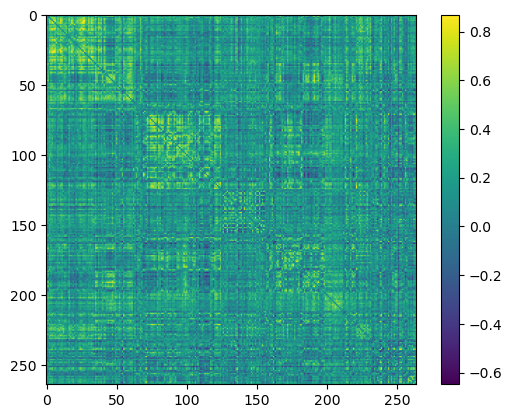

In [29]:
import matplotlib.pyplot as plt

# plt.imshow(remap(vec2mat(xhat[0])))
plt.imshow(remap(vec2mat(rest[0])))
plt.colorbar()
plt.show()

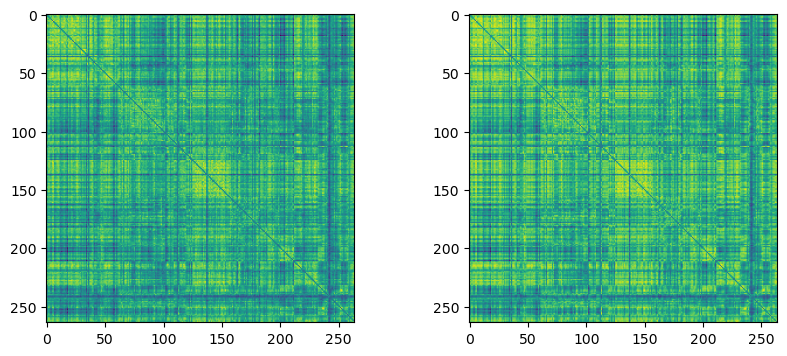

In [32]:
idx = 3

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(remap(vec2mat(xhat[idx])))
ax[1].imshow(remap(vec2mat(rest[idx])))
fig.show()

In [33]:
# Get latent vectors for mixup

z = []

with torch.no_grad():
    for bs in range(0, len(x), bsize):
        xb = x[bs:bs+bsize]
        zz = mae.enc(xb).squeeze().cpu().numpy()
        z.append(zz)

z = np.concatenate(z)
print(z.shape)

(1387, 2000)


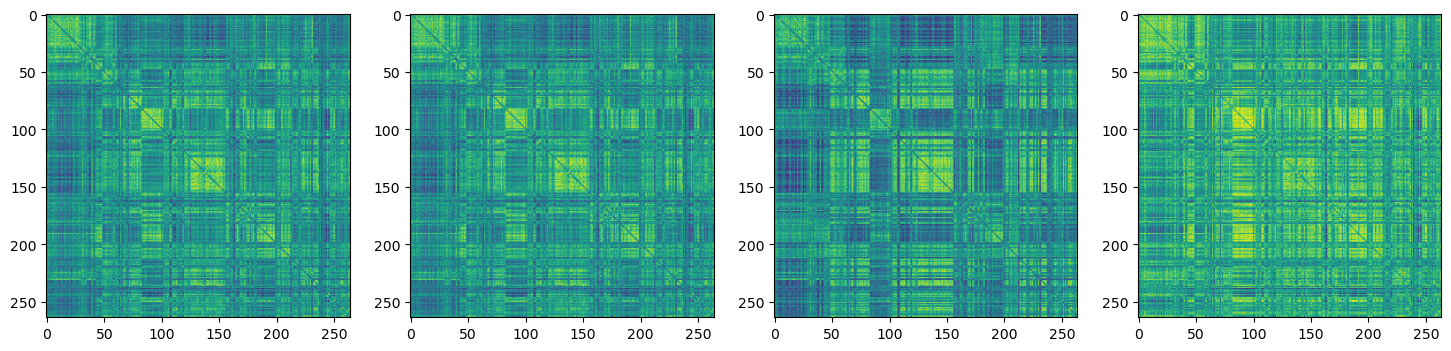

In [48]:
# Try random mixup

i1 = 15
i2 = 40

z1 = (z[i1]+z[i2])/2
y1 = (xhat[i1]+xhat[i2])/2

with torch.no_grad():
    zz1 = torch.from_numpy(z1).unsqueeze(0).float().cuda()
    x1 = mae.dec(zz1).squeeze().cpu().numpy()

fig, ax = plt.subplots(1, 4, figsize=(18,4))
ax[0].imshow(remap(vec2mat(x1)))
ax[1].imshow(remap(vec2mat(y1)))
ax[2].imshow(remap(vec2mat(xhat[i1])))
ax[3].imshow(remap(vec2mat(xhat[i2])))
fig.show()